In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **Available activation functions**

In [1]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - x**2

# **Single layer definition**

In [2]:
class Layer:
    
    def __init__(self, input_dim, output_dim, activation='sigmoid', weights_init='uniform'):
        """
        Initializes a single layer in the neural network.

        Parameters:
        - input_dim (int): Number of input neurons (features).
        - output_dim (int): Number of output neurons.
        - activation (str, optional): Activation function to use ('sigmoid' by default). 
          Supported: 'sigmoid', 'linear', 'relu', 'tanh'.
        - weights_init (str, optional): Weight initialization method ('uniform' by default).
          Available methods:
            - 'uniform' : Weights initialized from a uniform distribution.
            - 'normal'  : Weights initialized from a normal distribution.
            - 'xavier'  : Xavier/Glorot initialization (good for tanh).
            - 'he'      : He initialization (good for ReLU).

        Raises:
        - ValueError: If an unknown weight initialization method or activation function is provided.
        """
        
        weight_initializers = {
            'uniform': lambda: np.random.uniform(0, 1, size=(input_dim, output_dim)),
            'normal': lambda: np.random.randn(input_dim, output_dim),  
            'xavier': lambda: np.random.randn(input_dim, output_dim) * np.sqrt(2 / (input_dim + output_dim)),
            'he': lambda: np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim) 
        }

        if weights_init not in weight_initializers:
            raise ValueError(f"Unknown initialization method: {weights_init}. Available: {list(weight_initializers.keys())}")

        self.weights = weight_initializers[weights_init]()
        self.biases = np.zeros((1, output_dim))
        
        activation_functions = {
            'sigmoid' : sigmoid,
            'linear' : linear,
            'relu' : relu,
            'tanh' : tanh
        }
        
        activation_derivatives = {  
            'sigmoid': sigmoid_derivative,
            'linear': linear_derivative,
            'relu' : relu_derivative,
            'tanh' : tanh_derivative
        }

        self.activation = activation_functions.get(activation)
        self.activation_derivative = activation_derivatives.get(activation)
        
        if self.activation is None:
            raise ValueError(f"Unknown activation function: {activation}. Available: {list(activation_functions.keys())}")

        
    def forward(self, X):
        """
        Performs forward propagation through the layer.

        Parameters:
        - X (numpy array): Input data (shape: number of samples × input features).

        Returns:
        - numpy array: Activated output of the layer.
        """
        return self.activation(np.dot(X, self.weights) + self.biases)


# **MLP with backpropagation, momentum and RMSProp**

In [3]:
class MLP:
    
    def __init__(self, layers, weights_init='uniform'):
        """
        Initializes the multi-layer perceptron (MLP).
        
        Parameters:
        - layers (list of dicts): Each dictionary defines a Layer object with keys:
            - 'input_dim' (int): Number of input neurons.
            - 'output_dim' (int): Number of output neurons.
            - 'activation' (str): Activation function name.
        - weights_init (str, optional): Method for weight initialization ('uniform' by default).
        """
        self.layers = [Layer(layer['input_dim'], layer['output_dim'], layer['activation'], weights_init) for layer in layers]
        self.weights_history = []


    def feedforward(self, X):
        """
        Performs forward propagation through the network.
        
        Parameters:
        - X (numpy array): Input data (shape: number of samples × input features).

        Returns:
        - activations (list of numpy arrays): Activations of each layer including input and output.
        """
        activations = [X]
        for i, layer in enumerate(self.layers):
            activations.append(layer.forward(activations[i]))
        return activations


    def predict(self, X):
        """
        Computes the network's output for given input data.
        
        Parameters:
        - X (numpy array): Input data.

        Returns:
        - numpy array: The final network output (predicted values).
        """
        return np.array(self.feedforward(X)[-1]).reshape(-1,)


    def train(self, 
        X_train, 
        y_train, 
        epochs=500, 
        learning_rate=0.1, 
        batch_size=None,
        optimizer=None, 
        beta=0.9,  
        epsilon=1e-8 
        ):
        """
        Trains the neural network using mini-batch gradient descent and backpropagation.

        Parameters:
        - X_train (numpy array): Training input data.
        - y_train (numpy array): Training target values.
        - epochs (int, optional): Number of training iterations (default is 500).
        - learning_rate (float, optional): Step size for weight updates (default is 0.1).
        - batch_size (int, optional): Number of samples per batch. If None, full-batch is used.
        - optimizer (str, optional): 'momentum' or 'rmsprop' to apply these optimizers. Default is None.
        - beta (float, optional): Momentum and RMSProp smoothing constant. Default is 0.9.
        - epsilon (float, optional): Small constant for numerical stability in RMSProp. Default is 1e-8.

        Returns:
        - None (prints training progress and plots weight evolution).
        """
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        mses = []
        self.weights_history = []

        if batch_size is None:
            batch_size = len(X_train)

        if optimizer == 'momentum':
            velocity_w = [np.zeros_like(layer.weights) for layer in self.layers]
            velocity_b = [np.zeros_like(layer.biases) for layer in self.layers]
        elif optimizer == 'rmsprop':
            caches_w = [np.zeros_like(layer.weights) for layer in self.layers]
            caches_b = [np.zeros_like(layer.biases) for layer in self.layers]

        for epoch in range(epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)

            for i in range(0, len(X_train), batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices].reshape(-1, 1)

                weights_error = [np.zeros_like(layer.weights) for layer in self.layers]
                biases_error = [np.zeros_like(layer.biases) for layer in self.layers]

                activations = self.feedforward(X_batch)

                weights_error, biases_error = self.backpropagate(activations, y_batch)

                for j, layer in enumerate(self.layers):
                    if optimizer == 'momentum':
                        velocity_w[j] = beta * velocity_w[j] + learning_rate * weights_error[j]
                        layer.weights -= velocity_w[j]
                        velocity_b[j] = beta * velocity_b[j] + learning_rate * biases_error[j]
                        layer.biases -= velocity_b[j]
                    elif optimizer == 'rmsprop':
                        caches_w[j] = beta * caches_w[j] + (1 - beta) * np.square(weights_error[j])
                        layer.weights -= learning_rate * weights_error[j] / (np.sqrt(caches_w[j]) + epsilon)
                        caches_b[j] = beta * caches_b[j] + (1 - beta) * np.square(biases_error[j])
                        layer.biases -= learning_rate * biases_error[j] / (np.sqrt(caches_b[j]) + epsilon)
                    else:
                        layer.weights -= learning_rate * weights_error[j]
                        layer.biases -= learning_rate * biases_error[j]

            self.weights_history.append([layer.weights.copy() for layer in self.layers])

            y_pred = self.predict(X_train)
            tmp_mse = self.mse(y_pred, y_train)
            
            print(f"\nEpoch {epoch + 1}/{epochs}. MSE = {tmp_mse}.")
            mses.append(tmp_mse)

        plt.figure()
        plt.plot(range(epochs), mses, 'o')
        plt.show()
        self.plot_weights_evolution()


    def plot_weights_evolution(self):
        """
        Plots the evolution of weights over epochs for each layer.

        Returns:
        - None (displays plots).
        """
        epochs = len(self.weights_history)
        for layer_idx in range(len(self.layers)):
            weights_per_epoch = np.array([epoch[layer_idx] for epoch in self.weights_history])  
            
            num_weights = weights_per_epoch[0].size  
            weights_per_epoch = weights_per_epoch.reshape(epochs, num_weights)

            plt.figure(figsize=(8, 5))
            for w in range(num_weights):
                plt.plot(range(epochs), weights_per_epoch[:, w], label=f'Weight {w}', alpha=0.7)

            plt.title(f'Weight Evolution in Layer {layer_idx + 1}')
            plt.xlabel('Epoch')
            plt.ylabel('Weight Value')
            plt.legend()
            plt.show()                   
    
    
    def backpropagate(self, activations, y_batch):
        """
        Performs backpropagation to compute gradients for weight and bias updates.

        Parameters:
        - activations (list of numpy arrays): Activations from feedforward pass.
        - y_batch (numpy array): Expected output.

        Returns:
        - Tuple (weight_gradients, bias_gradients) where:
            - weight_gradients (list of numpy arrays): Gradients for each layer’s weights.
            - bias_gradients (list of numpy arrays): Gradients for each layer’s biases.
        """
        
        batch_size = y_batch.shape[0]

        y_pred = activations[-1]  
        error = (y_pred - y_batch).reshape(-1, 1)
        
        deltas = [error * self.layers[-1].activation_derivative(y_pred)]

        for i in range(len(self.layers) - 2, -1, -1):
            layer = self.layers[i]
            next_layer = self.layers[i + 1]
            
            error = deltas[-1] @ next_layer.weights.T  
            deltas.append(error * layer.activation_derivative(activations[i + 1]))

        deltas.reverse() 

        weight_gradients = [(activations[i].T @ deltas[i]) / batch_size for i in range(len(self.layers))]
        bias_gradients = [np.mean(deltas[i], axis=0, keepdims=True) for i in range(len(self.layers))]

        return weight_gradients, bias_gradients
    
   
    def set_weights_and_biases(self, layer_idx, W, b):
        """
        Sets custom weights and biases for a specific layer.

        Parameters:
        - layer_idx (int): Index of the layer (0-based).
        - W (numpy array): New weight matrix for the layer.
        - b (numpy array): New bias vector for the layer.

        Returns:
        - None
        """
        self.layers[layer_idx].weights = W
        self.layers[layer_idx].biases = b


    def mse(self, y_true, y_pred):
        """
        Computes the Mean Squared Error (MSE) loss.

        Parameters:
        - y_true (numpy array): True target values.
        - y_pred (numpy array): Predicted values from the network.

        Returns:
        - float: Computed MSE loss.
        """
        return np.mean((y_true - y_pred) ** 2)


## **Square-large dataset with momentum**


Epoch 1/2000. MSE = 1598.8915731855388.

Epoch 2/2000. MSE = 829.3316765696944.

Epoch 3/2000. MSE = 298.56220122617066.

Epoch 4/2000. MSE = 2306.76486761483.

Epoch 5/2000. MSE = 262.5291966209159.

Epoch 6/2000. MSE = 622.3566168659809.

Epoch 7/2000. MSE = 654.4773973717112.

Epoch 8/2000. MSE = 135.7598614309945.

Epoch 9/2000. MSE = 584.8230355869155.

Epoch 10/2000. MSE = 107.59284921779332.

Epoch 11/2000. MSE = 80.12265213420176.

Epoch 12/2000. MSE = 137.031687416101.

Epoch 13/2000. MSE = 120.10328973733093.

Epoch 14/2000. MSE = 76.53777101610243.

Epoch 15/2000. MSE = 95.90623438292702.

Epoch 16/2000. MSE = 672.8947000726965.

Epoch 17/2000. MSE = 79.07860087149035.

Epoch 18/2000. MSE = 51.069034764451246.

Epoch 19/2000. MSE = 62.90385594607557.

Epoch 20/2000. MSE = 86.03504028390522.

Epoch 21/2000. MSE = 50.59406878356937.

Epoch 22/2000. MSE = 39.023969053730156.

Epoch 23/2000. MSE = 149.12117982907532.

Epoch 24/2000. MSE = 52.05960378518217.

Epoch 25/2000. MSE 

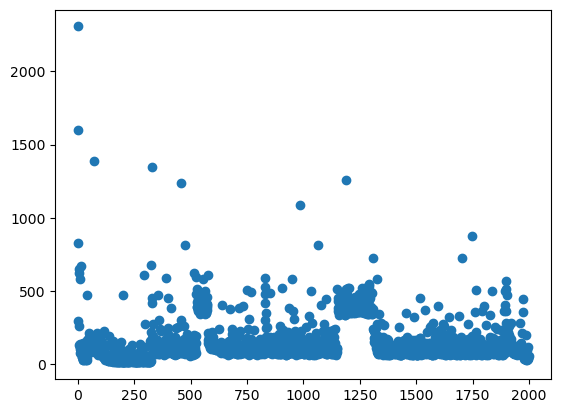

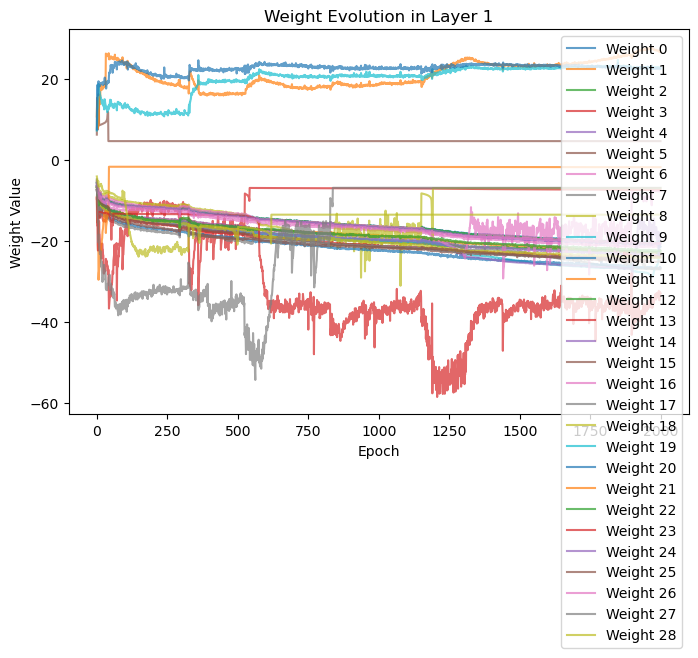

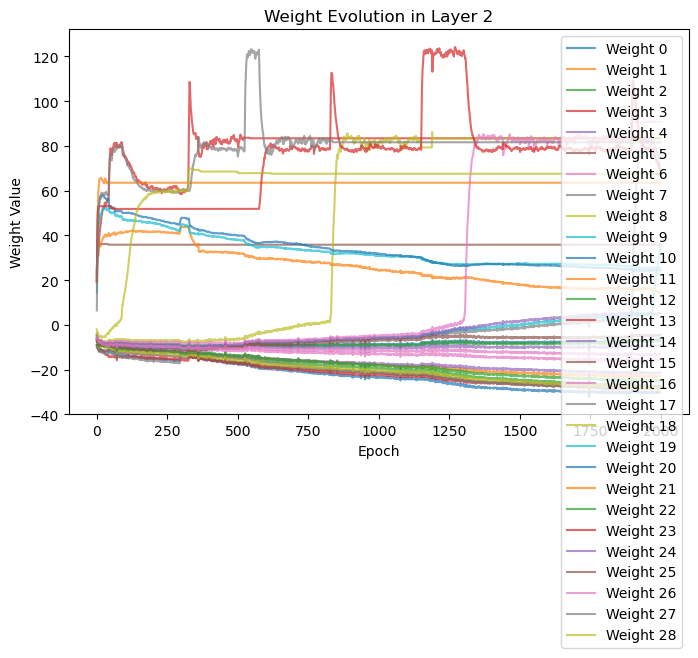

TRAIN MSE = 55.18476277128257
TEST MSE = 1339.038085474732


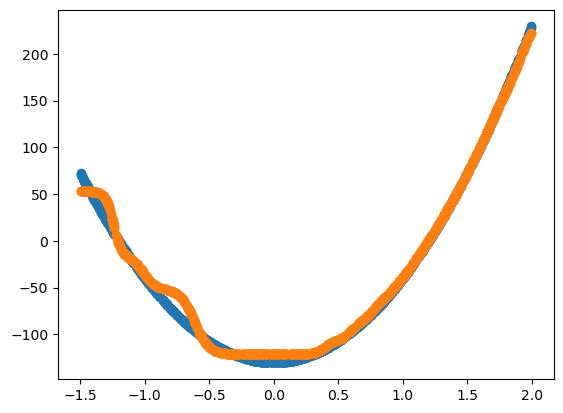

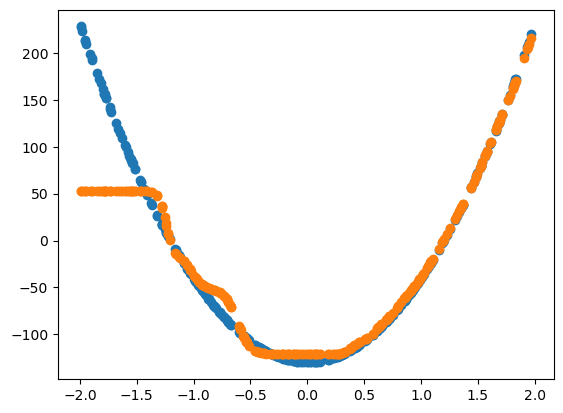

In [44]:
np.random.seed(423)

square_large_train = pd.read_csv('./data/regression/square-large-training.csv')
square_large_train.drop(square_large_train.columns[0], axis = 1, inplace = True)

X_train = square_large_train.iloc[:, 0:(len(square_large_train.iloc[1]) - 1)]
y_train = np.array(square_large_train.iloc[:,-1])

square_large_test = pd.read_csv('./data/regression/square-large-test.csv')
square_large_test.drop(square_large_test.columns[0], axis = 1, inplace = True)

X_test = square_large_test.iloc[:, 0:(len(square_large_test.iloc[1]) - 1)]

y_test = np.array(square_large_test['y'])

NN = MLP(layers=[
    {'input_dim' : 1, 'output_dim' : 29, 'activation' : 'sigmoid'},
    {'input_dim' : 29, 'output_dim' : 1, 'activation' : 'linear'}
], 
                   weights_init='xavier')

NN.train(X_train, y_train, epochs=2000, learning_rate=0.06, batch_size = 20, optimizer='momentum', beta=0.00003)

y_train_pred = NN.predict(X_train)
plt.figure()
plt.plot(X_train, y_train, 'o')
plt.plot(X_train, y_train_pred, 'o')
plt.show
print(f"TRAIN MSE = {NN.mse(y_train_pred, y_train)}")

y_test_pred = NN.predict(X_test)

plt.figure()
plt.plot(X_test, y_test, 'o')
plt.plot(X_test, y_test_pred, 'o')
plt.show
print(f"TEST MSE = {NN.mse(y_test_pred, y_test)}")



The training set has a different distribution of values on the x-axis, making it impossible to perfectly predict the values in the test set.

## **Square-large dataset with RMSProp**


Epoch 1/3000. MSE = 9749.091758769713.

Epoch 2/3000. MSE = 9715.366755768495.

Epoch 3/3000. MSE = 9674.330487995461.

Epoch 4/3000. MSE = 9622.453283959117.

Epoch 5/3000. MSE = 9565.47022784619.

Epoch 6/3000. MSE = 9499.280106653914.

Epoch 7/3000. MSE = 9421.085641816939.

Epoch 8/3000. MSE = 9332.922411052185.

Epoch 9/3000. MSE = 9236.611537917517.

Epoch 10/3000. MSE = 9139.443642216653.

Epoch 11/3000. MSE = 9037.305684568131.

Epoch 12/3000. MSE = 8924.078972239957.

Epoch 13/3000. MSE = 8803.693689552869.

Epoch 14/3000. MSE = 8677.433814602264.

Epoch 15/3000. MSE = 8541.598335634586.

Epoch 16/3000. MSE = 8402.832332928823.

Epoch 17/3000. MSE = 8257.941987655857.

Epoch 18/3000. MSE = 8115.854571547271.

Epoch 19/3000. MSE = 7965.769846777883.

Epoch 20/3000. MSE = 7809.24729320623.

Epoch 21/3000. MSE = 7654.004876552448.

Epoch 22/3000. MSE = 7493.731914804775.

Epoch 23/3000. MSE = 7338.481235250419.

Epoch 24/3000. MSE = 7190.160221307291.

Epoch 25/3000. MSE = 7032.

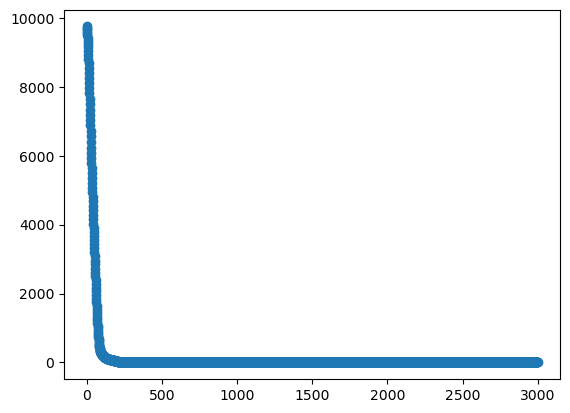

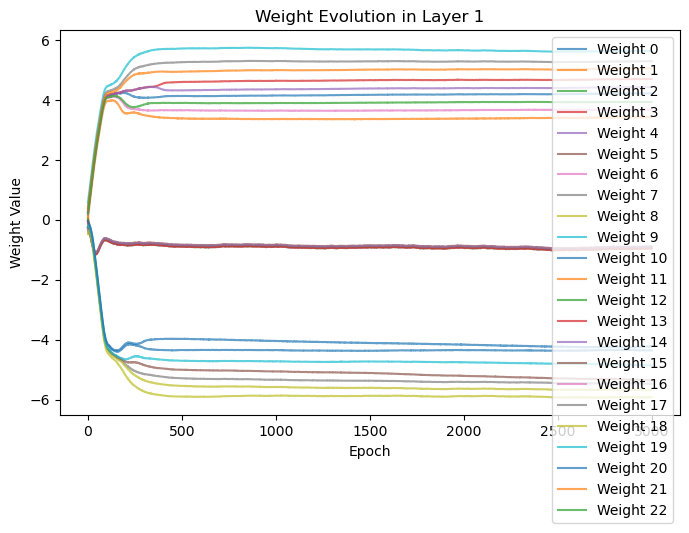

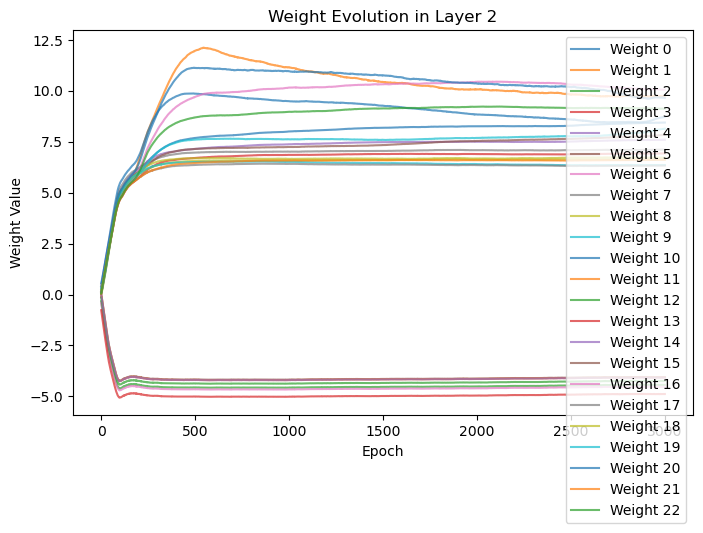

TRAIN MSE = 0.08974182992769332
TEST MSE = 33.537272842871495


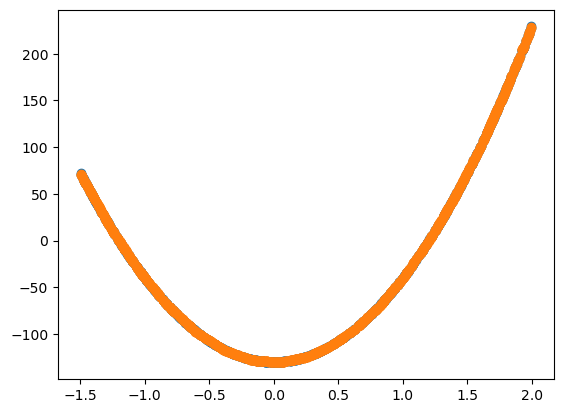

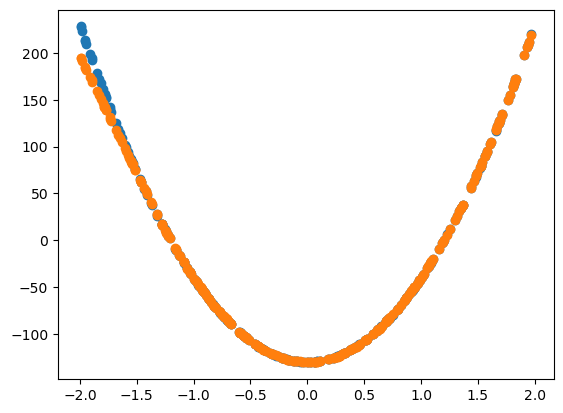

In [163]:
np.random.seed(23)

square_large_train = pd.read_csv('./data/regression/square-large-training.csv')
square_large_train.drop(square_large_train.columns[0], axis = 1, inplace = True)

X_train = square_large_train.iloc[:, 0:(len(square_large_train.iloc[1]) - 1)]
y_train = np.array(square_large_train.iloc[:,-1])

square_large_test = pd.read_csv('./data/regression/square-large-test.csv')
square_large_test.drop(square_large_test.columns[0], axis = 1, inplace = True)

X_test = square_large_test.iloc[:, 0:(len(square_large_test.iloc[1]) - 1)]
y_test = np.array(square_large_test['y'])

NN = MLP(layers=[
    {'input_dim' : 1, 'output_dim' : 23, 'activation' : 'relu'},
    {'input_dim' : 23, 'output_dim' : 1, 'activation' : 'linear'}
], 
                   weights_init='xavier')

NN.train(X_train, y_train, epochs=3000, learning_rate=0.002, batch_size = 30, optimizer='rmsprop', beta=0.53)

y_train_pred = NN.predict(X_train)
plt.figure()
plt.plot(X_train, y_train, 'o')
plt.plot(X_train, y_train_pred, 'o')
plt.show
print(f"TRAIN MSE = {NN.mse(y_train_pred, y_train)}")

y_test_pred = NN.predict(X_test)

plt.figure()
plt.plot(X_test, y_test, 'o')
plt.plot(X_test, y_test_pred, 'o')
plt.show
print(f"TEST MSE = {NN.mse(y_test_pred, y_test)}")



The training set has a different distribution of values on the x-axis, making it impossible to perfectly predict the values in the test set.

# **Steps-large dataset with momentum**


Epoch 1/15055. MSE = 7363.2374818369435.

Epoch 2/15055. MSE = 7344.137358001861.

Epoch 3/15055. MSE = 7317.349181597889.

Epoch 4/15055. MSE = 7284.189932444294.

Epoch 5/15055. MSE = 7246.115543888332.

Epoch 6/15055. MSE = 7204.800400313681.

Epoch 7/15055. MSE = 7162.058568557702.

Epoch 8/15055. MSE = 7119.530103815845.

Epoch 9/15055. MSE = 7078.355201749325.

Epoch 10/15055. MSE = 7039.13886856499.

Epoch 11/15055. MSE = 7002.1825750353055.

Epoch 12/15055. MSE = 6967.741850873509.

Epoch 13/15055. MSE = 6936.162795379582.

Epoch 14/15055. MSE = 6907.88348249087.

Epoch 15/15055. MSE = 6883.343231348045.

Epoch 16/15055. MSE = 6862.867243337688.

Epoch 17/15055. MSE = 6846.585498515029.

Epoch 18/15055. MSE = 6834.398296609271.

Epoch 19/15055. MSE = 6825.969174724841.

Epoch 20/15055. MSE = 6820.737455389768.

Epoch 21/15055. MSE = 6817.9557955971095.

Epoch 22/15055. MSE = 6816.743598717428.

Epoch 23/15055. MSE = 6816.130331894572.

Epoch 24/15055. MSE = 6815.069817256362.


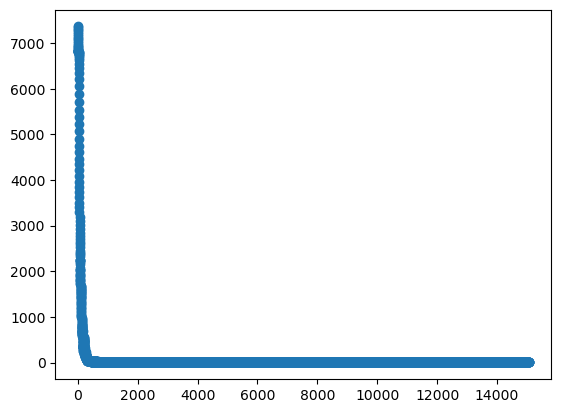

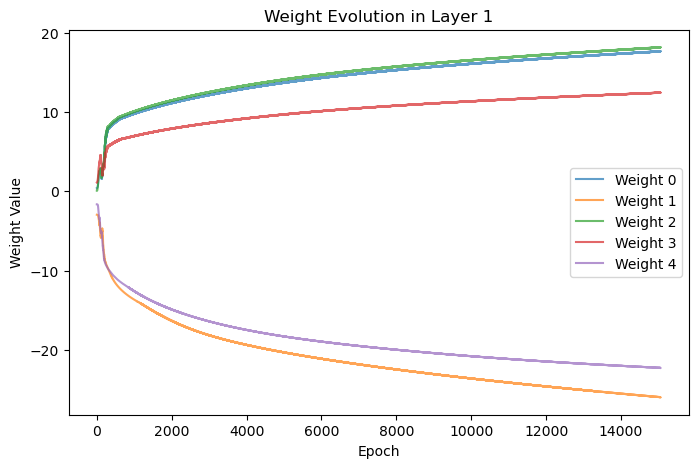

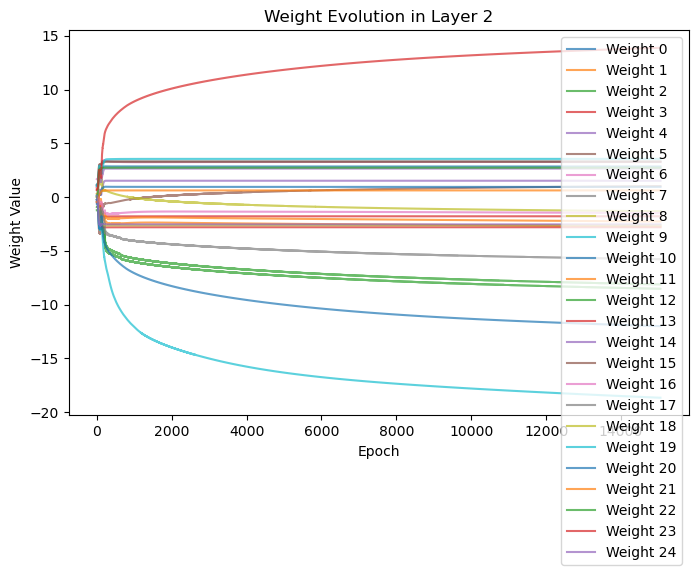

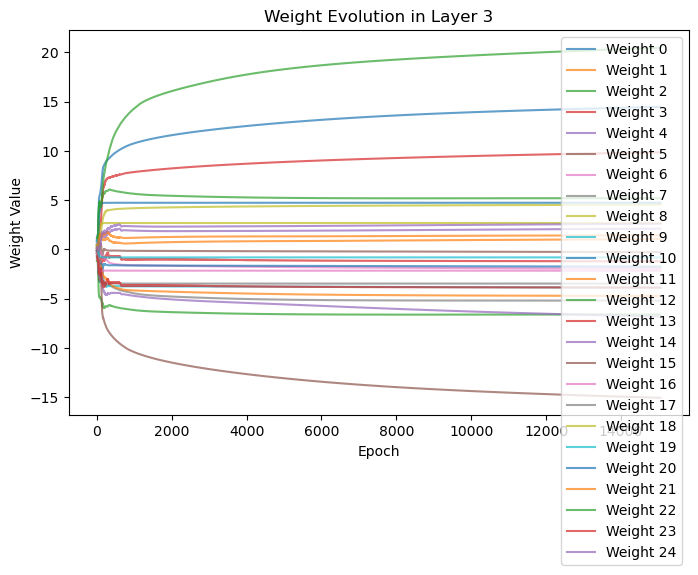

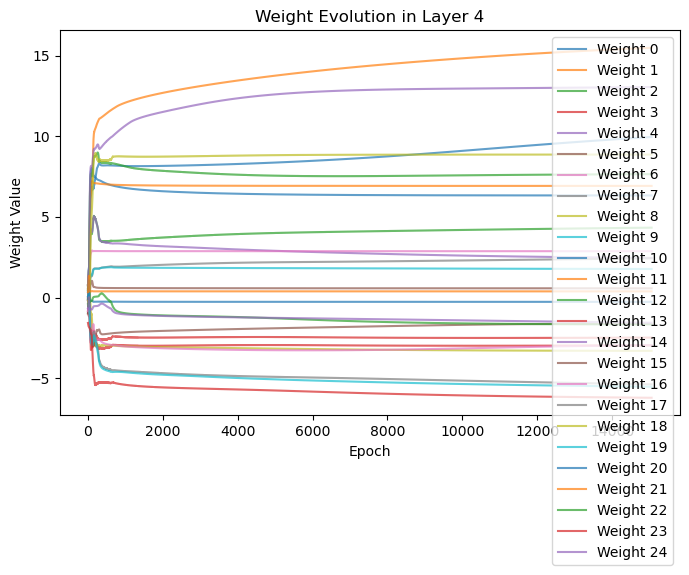

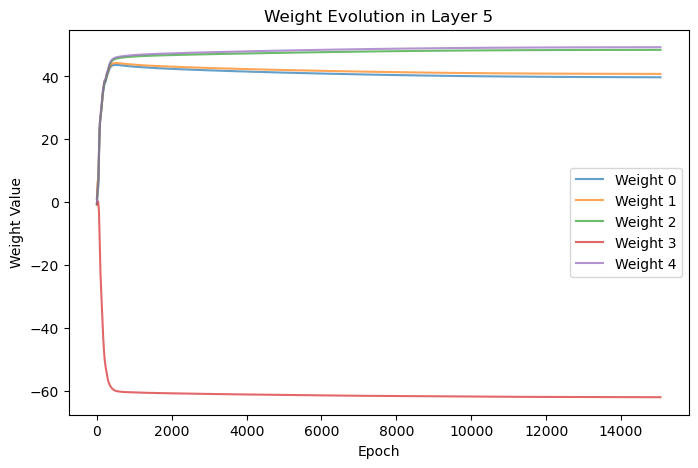

TRAIN MSE = 2.78586754435236
TEST MSE = 0.8688916673079846


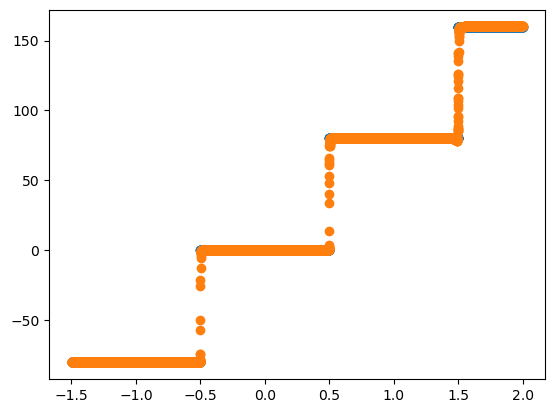

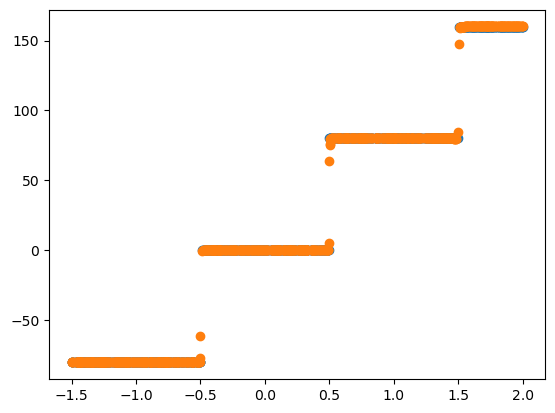

In [176]:
np.random.seed(423)
steps_large_train = pd.read_csv('./data/regression/steps-large-training.csv')
steps_large_train.drop(steps_large_train.columns[0], axis = 1, inplace = True)

X_train = steps_large_train.iloc[:, 0:(len(steps_large_train.iloc[1]) - 1)]

y_train = np.array(steps_large_train['y'])

steps_large_test = pd.read_csv('./data/regression/steps-large-test.csv')
steps_large_test.drop(steps_large_test.columns[0], axis = 1, inplace = True)

X_test = steps_large_test.iloc[:, 0:(len(steps_large_test.iloc[1]) - 1)]

y_test = np.array(steps_large_test['y'])

NN = MLP(layers=[
    {'input_dim' : 1, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 1, 'activation' : 'linear'}
], 
                   weights_init='he')

NN.train(X_train, y_train, epochs=15055, learning_rate=0.003, optimizer='momentum', beta=0.9)

y_train_pred = NN.predict(X_train)
plt.figure()
plt.plot(X_train, y_train, 'o')
plt.plot(X_train, y_train_pred, 'o')
plt.show
print(f"TRAIN MSE = {NN.mse(y_train_pred, y_train)}")

y_test_pred = NN.predict(X_test)

plt.figure()
plt.plot(X_test, y_test, 'o')
plt.plot(X_test, y_test_pred, 'o')
plt.show
print(f"TEST MSE = {NN.mse(y_test_pred, y_test)}")

# **Steps-large dataset with RMSProp**


Epoch 1/45000. MSE = 7369.349143662144. TEST MSE = 7443.405368745179

Epoch 2/45000. MSE = 7366.434100458858. TEST MSE = 7440.439645842297

Epoch 3/45000. MSE = 7364.004189426535. TEST MSE = 7437.96743063962

Epoch 4/45000. MSE = 7361.855533105406. TEST MSE = 7435.781318017867

Epoch 5/45000. MSE = 7359.893611475741. TEST MSE = 7433.785153083253

Epoch 6/45000. MSE = 7358.065852494973. TEST MSE = 7431.925454740405

Epoch 7/45000. MSE = 7356.339638693608. TEST MSE = 7430.169041854625

Epoch 8/45000. MSE = 7354.693187940943. TEST MSE = 7428.493756085407

Epoch 9/45000. MSE = 7353.11115810259. TEST MSE = 7426.883990375699

Epoch 10/45000. MSE = 7351.582298839509. TEST MSE = 7425.32830011655

Epoch 11/45000. MSE = 7350.098097513234. TEST MSE = 7423.818025667656

Epoch 12/45000. MSE = 7348.651949089735. TEST MSE = 7422.346447947923

Epoch 13/45000. MSE = 7347.23862134951. TEST MSE = 7420.908244434852

Epoch 14/45000. MSE = 7345.85389601301. TEST MSE = 7419.499124115356

Epoch 15/45000. MSE

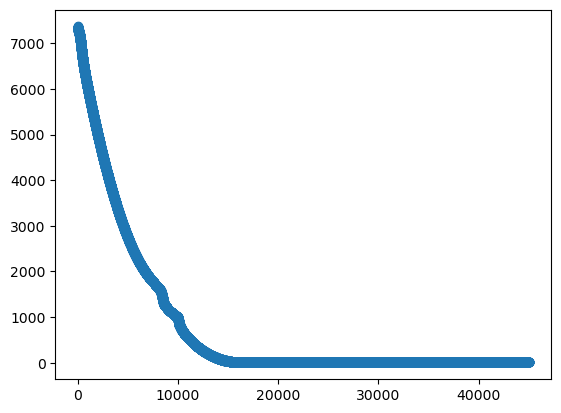

TRAIN MSE = 5.730841865503213
TEST MSE = 5.345281609945682


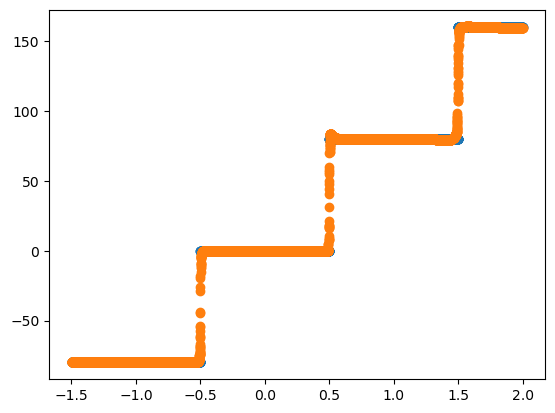

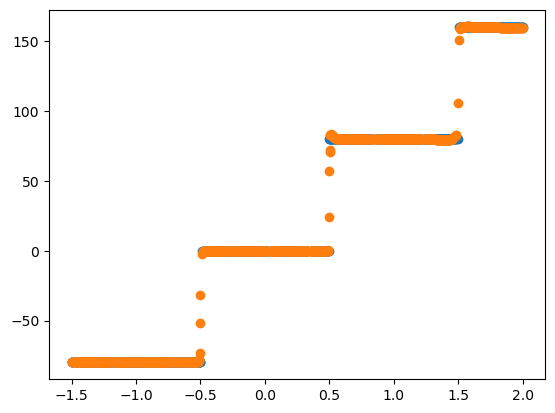

In [ ]:
np.random.seed(423)
steps_large_train = pd.read_csv('./data/regression/steps-large-training.csv')
steps_large_train.drop(steps_large_train.columns[0], axis = 1, inplace = True)

X_train = steps_large_train.iloc[:, 0:(len(steps_large_train.iloc[1]) - 1)]

y_train = np.array(steps_large_train['y'])

steps_large_test = pd.read_csv('./data/regression/steps-large-test.csv')
steps_large_test.drop(steps_large_test.columns[0], axis = 1, inplace = True)

X_test = steps_large_test.iloc[:, 0:(len(steps_large_test.iloc[1]) - 1)]

y_test = np.array(steps_large_test['y'])

NN = MLP(layers=[
    {'input_dim' : 1, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 5, 'activation' : 'sigmoid'},
    {'input_dim' : 5, 'output_dim' : 1, 'activation' : 'linear'}
], 
                   weights_init='he')

NN.train(X_train, y_train, epochs=25000, learning_rate=0.003, optimizer='rmsprop', beta=0.9)

y_train_pred = NN.predict(X_train)
plt.figure()
plt.plot(X_train, y_train, 'o')
plt.plot(X_train, y_train_pred, 'o')
plt.show
print(f"TRAIN MSE = {NN.mse(y_train_pred, y_train)}")

y_test_pred = NN.predict(X_test)

plt.figure()
plt.plot(X_test, y_test, 'o')
plt.plot(X_test, y_test_pred, 'o')
plt.show
print(f"TEST MSE = {NN.mse(y_test_pred, y_test)}")

Since the required mse was obtained on the above set, we will not train on this one as much.

# **Multimodal-large dataset with momentum**


Epoch 1/400. MSE = 1754.9269835035834.

Epoch 2/400. MSE = 1214.106963340752.

Epoch 3/400. MSE = 1075.2280036593256.

Epoch 4/400. MSE = 972.1746137097045.

Epoch 5/400. MSE = 922.6014273816315.

Epoch 6/400. MSE = 902.2491000143468.

Epoch 7/400. MSE = 878.6699711872454.

Epoch 8/400. MSE = 865.3784144249535.

Epoch 9/400. MSE = 671.7646198713371.

Epoch 10/400. MSE = 573.7926050272247.

Epoch 11/400. MSE = 552.6683722979092.

Epoch 12/400. MSE = 535.7655698840068.

Epoch 13/400. MSE = 531.6862500119832.

Epoch 14/400. MSE = 502.2606770083405.

Epoch 15/400. MSE = 532.2206535676567.

Epoch 16/400. MSE = 584.2101872828915.

Epoch 17/400. MSE = 497.2513214334652.

Epoch 18/400. MSE = 519.1462075304199.

Epoch 19/400. MSE = 515.179458146067.

Epoch 20/400. MSE = 570.7366008105807.

Epoch 21/400. MSE = 497.0432971191626.

Epoch 22/400. MSE = 495.38601418741905.

Epoch 23/400. MSE = 497.13987797152987.

Epoch 24/400. MSE = 489.47080271502927.

Epoch 25/400. MSE = 487.40264519092625.

Epo

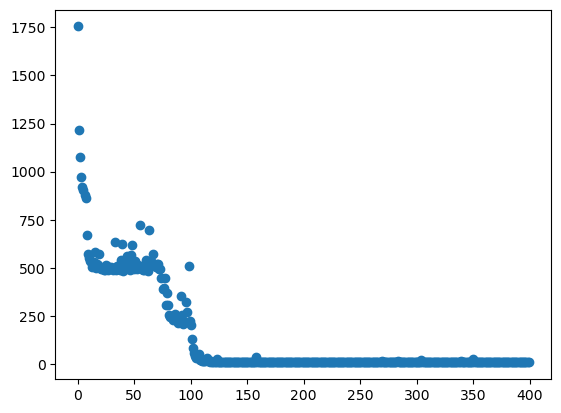

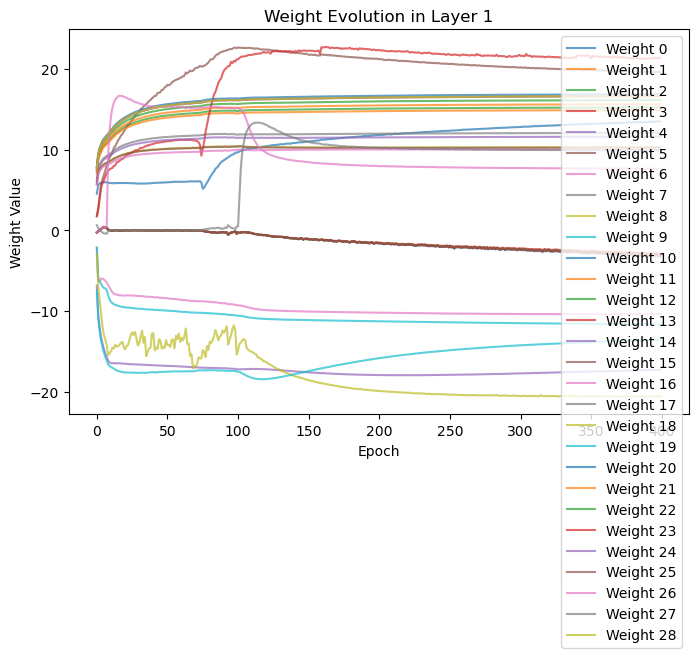

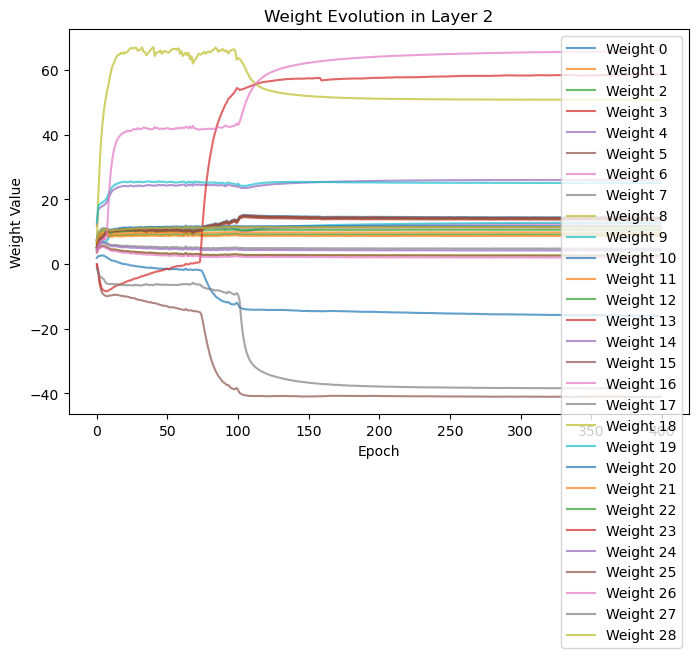

TRAIN MSE = 7.913140785952355
TEST MSE = 3.930109362812906


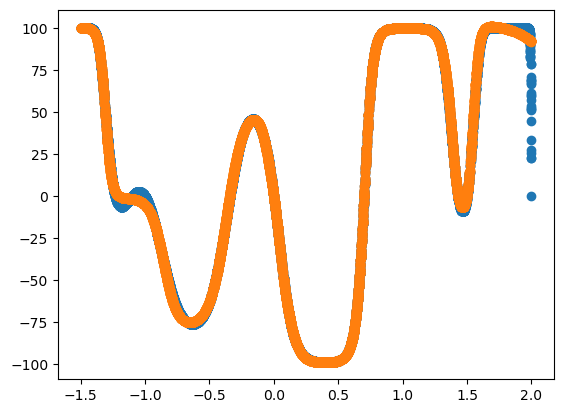

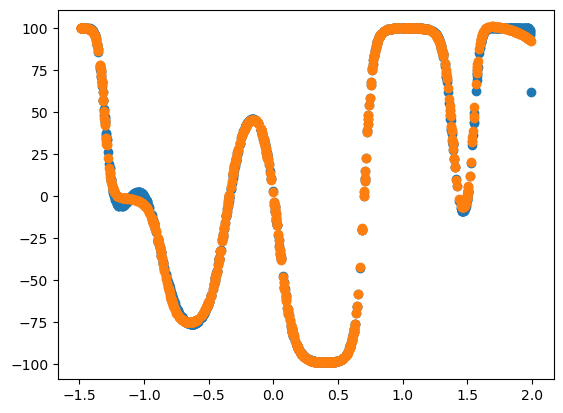

In [100]:
np.random.seed(23)
multimodal_large_train = pd.read_csv('./data/regression/multimodal-large-training.csv')
X_train = np.array(multimodal_large_train['x']).reshape(-1, 1)
y_train = np.array(multimodal_large_train['y'])

multimodal_large_test = pd.read_csv('./data/regression/multimodal-large-test.csv')
X_test = np.array(multimodal_large_test['x']).reshape(-1, 1)
y_test = np.array(multimodal_large_test['y'])

NN = MLP(layers=[
    {'input_dim' : 1, 'output_dim' : 29, 'activation' : 'tanh'},
    {'input_dim' : 29, 'output_dim' : 1, 'activation' : 'linear'}
], 
                   weights_init='uniform')

NN.train(X_train, y_train, epochs=400, learning_rate=0.005, batch_size = 120, optimizer='momentum', beta=0.8)

y_train_pred = NN.predict(X_train)
plt.figure()
plt.plot(X_train, y_train, 'o')
plt.plot(X_train, y_train_pred, 'o')
plt.show
print(f"TRAIN MSE = {NN.mse(y_train_pred, y_train)}")

y_test_pred = NN.predict(X_test)
plt.figure()
plt.plot(X_test, y_test, 'o')
plt.plot(X_test, y_test_pred, 'o')
plt.show
print(f"TEST MSE = {NN.mse(y_test_pred, y_test)}")

# **Multimodal-large dataset with RMSProp**


Epoch 1/1000. MSE = 3336.8517368419634.

Epoch 2/1000. MSE = 2836.391999994204.

Epoch 3/1000. MSE = 2330.5397410809314.

Epoch 4/1000. MSE = 1920.3557433895267.

Epoch 5/1000. MSE = 1703.5798561972902.

Epoch 6/1000. MSE = 1619.9451708689235.

Epoch 7/1000. MSE = 1577.4004747557092.

Epoch 8/1000. MSE = 1553.9527590354628.

Epoch 9/1000. MSE = 1504.9910761359324.

Epoch 10/1000. MSE = 1439.8610661266123.

Epoch 11/1000. MSE = 1374.3984109114751.

Epoch 12/1000. MSE = 1318.8593093131929.

Epoch 13/1000. MSE = 1272.5504685783128.

Epoch 14/1000. MSE = 1234.6480219377486.

Epoch 15/1000. MSE = 1200.4194986106686.

Epoch 16/1000. MSE = 1171.6902584363777.

Epoch 17/1000. MSE = 1144.3437158295699.

Epoch 18/1000. MSE = 1121.661218218872.

Epoch 19/1000. MSE = 1099.769479029578.

Epoch 20/1000. MSE = 1081.9782019225242.

Epoch 21/1000. MSE = 1065.986150222949.

Epoch 22/1000. MSE = 1053.2548789953792.

Epoch 23/1000. MSE = 1039.9356136802785.

Epoch 24/1000. MSE = 1025.1093325729696.

Epoc

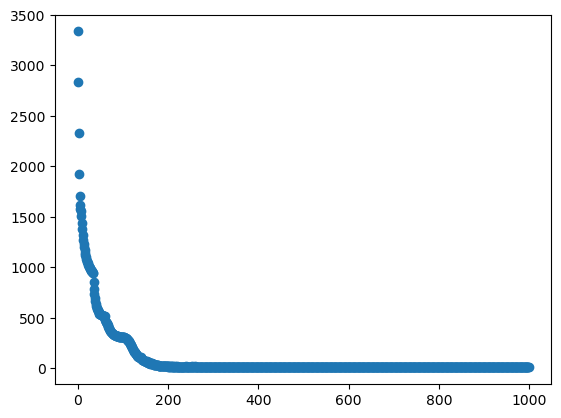

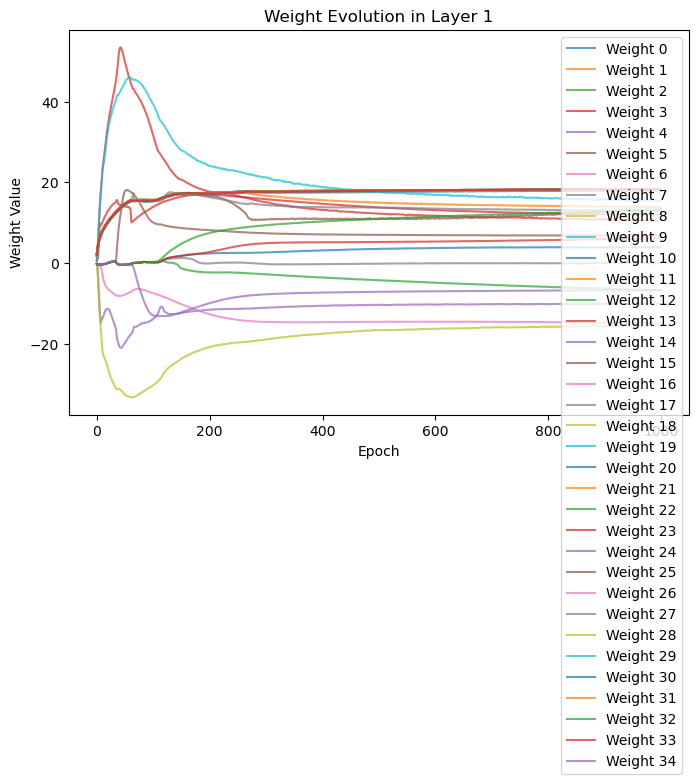

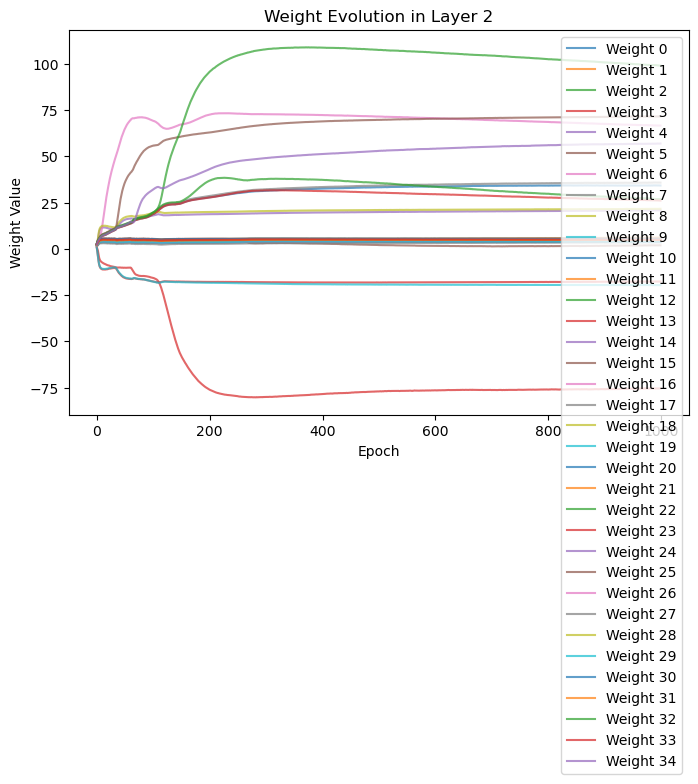

TRAIN MSE = 6.937397270191292
TEST MSE = 2.52098831557229


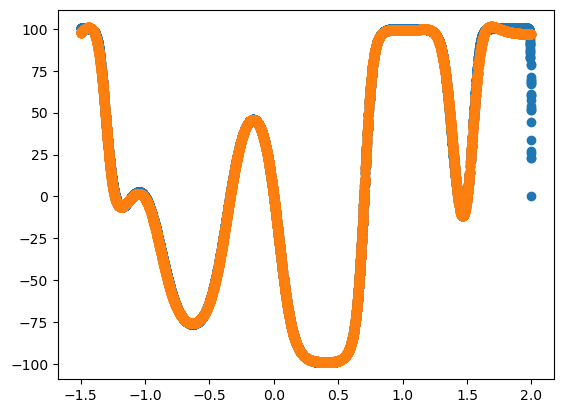

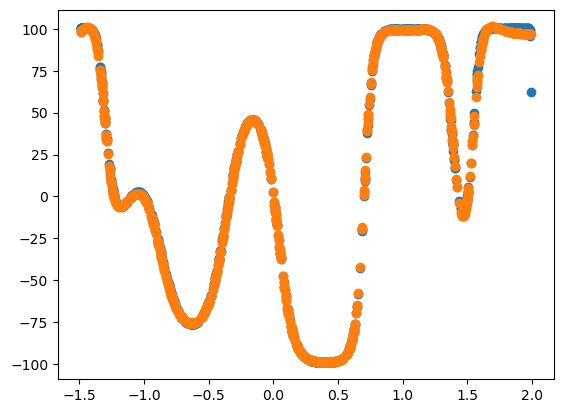

In [101]:
np.random.seed(23)
multimodal_large_train = pd.read_csv('./data/regression/multimodal-large-training.csv')
X_train = np.array(multimodal_large_train['x']).reshape(-1, 1)
y_train = np.array(multimodal_large_train['y'])

multimodal_large_test = pd.read_csv('./data/regression/multimodal-large-test.csv')
X_test = np.array(multimodal_large_test['x']).reshape(-1, 1)
y_test = np.array(multimodal_large_test['y'])

NN = MLP(layers=[
    {'input_dim' : 1, 'output_dim' : 35, 'activation' : 'tanh'},
    {'input_dim' : 35, 'output_dim' : 1, 'activation' : 'linear'}
], 
                   weights_init='uniform')

NN.train(X_train, y_train, epochs=1000, learning_rate=0.01, batch_size = 30, optimizer='rmsprop', beta=0.9)

y_train_pred = NN.predict(X_train)
plt.figure()
plt.plot(X_train, y_train, 'o')
plt.plot(X_train, y_train_pred, 'o')
plt.show
print(f"TRAIN MSE = {NN.mse(y_train_pred, y_train)}")

y_test_pred = NN.predict(X_test)
plt.figure()
plt.plot(X_test, y_test, 'o')
plt.plot(X_test, y_test_pred, 'o')
plt.show
print(f"TEST MSE = {NN.mse(y_test_pred, y_test)}")

As we can see, the momentum method is faster.